# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 

#### Victor Roy

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
import cv2
import os
%matplotlib inline

# Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


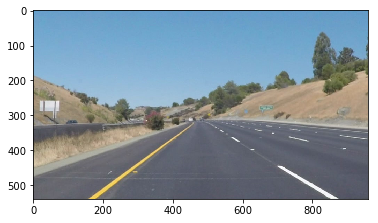

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidYellowCurve2.jpg')
image_shape = image.shape

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image_shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Helper Functions

In [3]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def sharpen(img, alpha=30):
    blurred = gaussian_blur(img, 3)
    filter_blurred = gaussian_blur(blurred,1)
    sharpened = blurred + alpha*(blurred-filter_blurred)
    return sharpened
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def line_locker(LHS_avg_slope, LHS_avg_intercept, RHS_avg_slope, RHS_avg_intercept, y_min, y_max):
    global LHS_locker 
    global RHS_locker
    global first_frame
    
    
    LHS = np.array([(LHS_avg_slope, LHS_avg_intercept)], dtype = [('slope',float),('intercept', float)])
    RHS = np.array([(RHS_avg_slope, RHS_avg_intercept)], dtype = [('slope',float),('intercept', float)])
    
    if first_frame:
        LHS_locker = LHS
        RHS_locker = RHS
        global first_frame
        first_frame = False
    else:
        LHS_locker = np.concatenate((LHS_locker, LHS))
        RHS_locker = np.concatenate((RHS_locker, RHS))
        
    global y_min_global
    y_min_global = y_min
    global y_max_global
    y_max_global = y_max
    
    return

def process_lines(lines):
    
    """
    Lines in format: [[X-start, Y-start, X-end, Y-end]]
    """
    
    center = image_shape[1]/2
    y_max = image_shape[0]
    
    LHS_lines = []
    RHS_lines = []
    
    # Sort lines into those on LHS & RHS
    # Only retain lines with correct slopes for their respective side
    for line in lines:
        if line[0][0] != line[0][2]:
            slope = (line[0][3]-line[0][1])/(line[0][2]-line[0][0])
            if (line[0][0] < center) & (line[0][2] < center) & (slope < 0):
                LHS_lines.append(tuple(line[0]))
            elif (line[0][0] >= center) & (line[0][2] >= center) & (slope > 0):
                RHS_lines.append (tuple(line[0]))
    
    LHS_lines = np.array(LHS_lines, dtype = [('X1', int), ('Y1',int), ('X2', int), ('Y2', int)])
    RHS_lines = np.array(RHS_lines, dtype = [('X1', int), ('Y1',int), ('X2', int), ('Y2', int)])
    
    # Choose n # of line extreme endpoints (highest & lowest Y) to create smoothed lines
    n=2
    LHS_lines.sort(order = 'Y1')
    LHS_high = LHS_lines[-n:]
    
    LHS_lines.sort(order = 'Y2')
    LHS_low = LHS_lines[0:n]
    
    RHS_lines.sort(order = 'Y2')
    RHS_high = RHS_lines[-n:]
    RHS_lines.sort(order = 'Y1')
    RHS_low = RHS_lines[0:n]
    
    new_LHS_lines = []
    new_RHS_lines = []

    for i in LHS_high:
        for j in LHS_low:
            new_LHS_lines.append(tuple([i[0],i[1],j[2],j[3]]))

    for i in RHS_high:
        for j in RHS_low:
            new_RHS_lines.append(tuple([j[0],j[1],i[2],i[3]]))
    
    new_LHS_lines = np.array(new_LHS_lines, dtype = [('X1', int), ('Y1',int), ('X2', int), ('Y2', int)])
    new_RHS_lines = np.array(new_RHS_lines, dtype = [('X1', int), ('Y1',int), ('X2', int), ('Y2', int)])
    
    # Calculate slopes and intercepts (as well as averages of those) of new smoothed lines        
    new_LHS_slopes = np.array((new_LHS_lines['Y2']-new_LHS_lines['Y1'])/(new_LHS_lines['X2']-new_LHS_lines['X1']))
    new_LHS_intercepts = np.array((new_LHS_lines['Y2']-new_LHS_lines['X2']*new_LHS_slopes))
    LHS_avg_slope = np.median(new_LHS_slopes)
    LHS_avg_intercept = np.median(new_LHS_intercepts)
    
    new_RHS_slopes = np.array((new_RHS_lines['Y2']-new_RHS_lines['Y1'])/(new_RHS_lines['X2']-new_RHS_lines['X1']))
    new_RHS_intercepts = np.array((new_RHS_lines['Y2']-new_RHS_lines['X2']*new_RHS_slopes))
    RHS_avg_slope = np.median(new_RHS_slopes)
    RHS_avg_intercept = np.median(new_RHS_intercepts)
    
    # Note extreme values of Y of hough lines for purposes of extrapolation
    y_min = min(LHS_lines['Y1'].min(), RHS_lines['Y2'].min(), y_min_global)
    y_max = max(LHS_lines['Y2'].max(), RHS_lines['Y1'].max(), y_max_global)
    
    # Store averaged line values
    line_locker(LHS_avg_slope, LHS_avg_intercept, RHS_avg_slope, RHS_avg_intercept, y_min, y_max)
    
    global LHS_locker
    global RHS_locker
    
    # Final line will be smoothed over m # of frames
    # Weights decreasing with respect to # of frames removed from current frame
    m = 7
    LHS_avg_slope = np.average(LHS_locker['slope'][-m:], weights = 2*np.arange(len(LHS_locker['slope'][-m:]),0,-1))
    LHS_avg_intercept = np.average(LHS_locker['intercept'][-m:], weights = 2*np.arange(len(LHS_locker['intercept'][-m:]),0,-1))
    RHS_avg_slope = np.average(RHS_locker['slope'][-m:], weights = 2*np.arange(len(RHS_locker['slope'][-m:]),0,-1))
    RHS_avg_intercept = np.average(RHS_locker['intercept'][-m:], weights = 2*np.arange(len(RHS_locker['intercept'][-m:]),0,-1))
    
    # New lines are created with smoothed lines, averaged over m # of frames
    LHS_final_line = [[int((y_min-LHS_avg_intercept)/LHS_avg_slope), y_min, int((y_max-LHS_avg_intercept)/LHS_avg_slope), y_max]]
    RHS_final_line = [[int((y_max-RHS_avg_intercept)/RHS_avg_slope), y_max, int((y_min-RHS_avg_intercept)/RHS_avg_slope), y_min]]

    smoothed_lines = [LHS_final_line, RHS_final_line]
    
    return smoothed_lines


def draw_lines(lines, color=[255, 0, 0], thickness=2):
    '''
    draw_lines function now recieves an array of lines as an argument
    and draws them upon a black background
    
    the processing of lines is done above, in process_lines
    '''
    
    
    img = np.zeros((image_shape[0], image_shape[1], 3), dtype=np.uint8)
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
    return img

    
    #print('Avg len of lines: {0}'.format(cum_length/len(lines)))
        
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
    
    Lines in format: [X-start, Y-start, X-end, Y-end]
    
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    #line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #draw_lines(line_img, lines)
    return lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.6, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [5]:
x_max = image.shape[1]
y_max = image.shape[0]

def process_image(image, kernel_size, low_threshold, high_threshold, mask, rho, theta, threshold, min_line_len, max_line_gap, to_print = False, to_file = None):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
  
    grayed = grayscale(image)
    
    blurred = gaussian_blur(grayed, kernel_size)

    cannied = canny(blurred, low_threshold, high_threshold)
    
    masked = region_of_interest(cannied, vertices=mask)

    houghed_lines = hough_lines(masked, rho, theta, threshold, min_line_len, max_line_gap)
    
    drawn_houghed = draw_lines(houghed_lines)
    
    processed_lines = process_lines(houghed_lines)
    
    drawn_lines = draw_lines(processed_lines)
    
    result = weighted_img(drawn_lines, image)
    
    if to_print:
        plt.close('all')
        fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,11))
        
        im1 = ax1.imshow(cannied, cmap='gray')
        im2 = ax2.imshow(drawn_houghed)
        im3 = ax3.imshow(result)
        
        plt.show()
        
    if to_file is not None: 
        plt.close('all')
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (16,11))
        fig.suptitle('Pipeline Images for {}'.format(to_file), fontsize = 16)
        im1 = ax1.imshow(cannied, cmap='gray')
        ax1.set_title('Canny Transform')
        im2 = ax2.imshow(drawn_houghed)
        ax2.set_title('Hough Lines')
        im3 = ax3.imshow(drawn_lines)
        ax3.set_title('Processed Lines')
        im4 = ax4.imshow(result)
        ax4.set_title('Result')
        
        plt.savefig('test_images_out/{}.jpg'.format(to_file), bbox_inches='tight', pad_inches = 0.05)
        
        plt.close('all')

    return result

def process_regular_image(image, to_file = None):
    mask_vertices = np.array([[(0,y_max),(x_max/2-30, y_max/2+60), (x_max/2+30, y_max/2+60), (x_max,y_max)]], dtype=np.int32)
    
    kwargs = {'kernel_size': 1,
              'low_threshold': 75,
              'high_threshold': 225,
              'mask': mask_vertices,
              'rho': 1,
              'theta': 1,
              'threshold': 10,
              'min_line_len': 10,
              'max_line_gap': 75,
              'to_print': True,
              'to_file': to_file
             }
    
    result = process_image(image, **kwargs)
    
    return result
    
    
def process_regular_video(image):
    
    mask_vertices = mask_vertices = np.array([[(0,y_max),(x_max/2-30, y_max/2+60), (x_max/2+30, y_max/2+60), (x_max,y_max)]], dtype=np.int32)
    
    kwargs = {'kernel_size': 1,
              'low_threshold': 75,
              'high_threshold': 225,
              'mask': mask_vertices,
              'rho': 1,
              'theta': 1,
              'threshold': 10,
              'min_line_len': 10,
              'max_line_gap': 75,
              'to_print': False
             }
    
    result = process_image(image, **kwargs)
    return result
    
def process_challenge_video(image):
    mask_vertices = np.array([[(200,y_max-50),(550, 575), (800, 475), (1200,y_max-50)]], dtype=np.int32)
    
    kwargs = {'kernel_size': 1,
              'low_threshold': 50,
              'high_threshold': 100,
              'mask': mask_vertices,
              'rho': 1,
              'theta': 1,
              'threshold': 2,
              'min_line_len': 10,
              'max_line_gap': 50,
             }
    
    result = process_image(image, **kwargs)
    return result

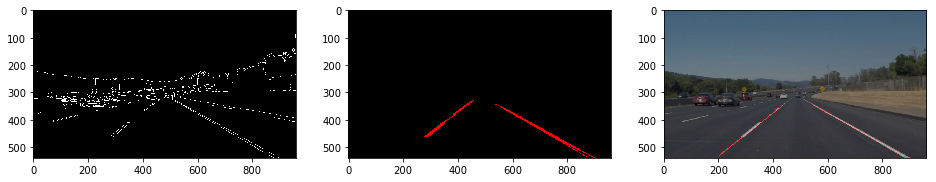

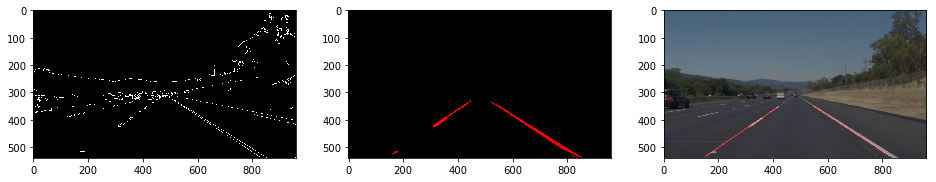

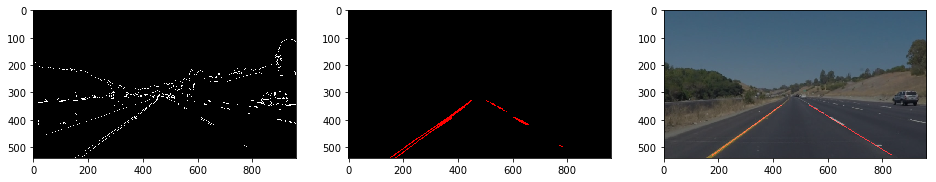

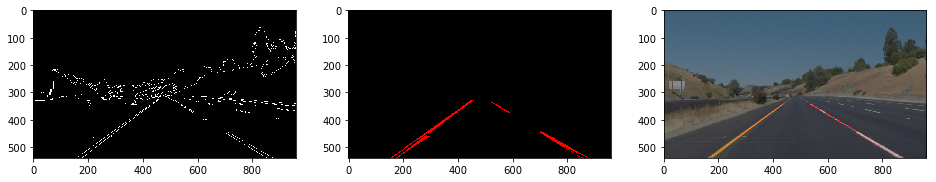

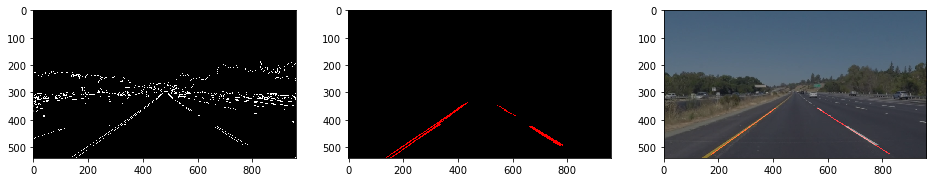

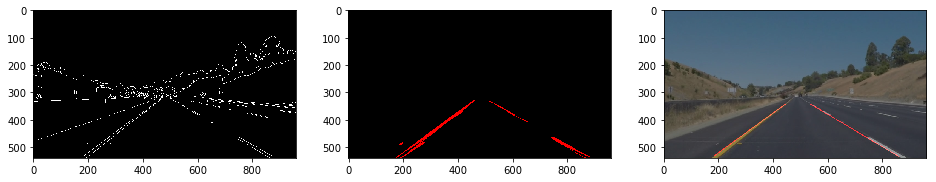

In [6]:
for file in os.listdir('test_images/'):
    
    global first_frame
    first_frame = True
    global LHS_locker
    global RHS_locker
    LHS_locker = np.empty([1,],dtype = [('slope', float), ('intercept',float)])
    RHS_locker = np.empty([1,],dtype = [('slope', float), ('intercept',float)])
    
    global y_min_global
    global y_max_global
    y_min_global = 960
    y_max_global = 0
    
    
    image = mpimg.imread('test_images/'+file)

    process_regular_image(image, to_file=file)

## Test on Videos

Let's try the one with the solid white lane on the right first ...

In [7]:
first_frame = True
LHS_locker = np.empty([1,],dtype = [('slope', float), ('intercept',float)])
RHS_locker = np.empty([1,],dtype = [('slope', float), ('intercept',float)])
y_min_global = 960
y_max_global = 0

white_output = 'white.mp4'

clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_regular_video) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:08<00:00, 25.73it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 9.85 s


In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

Now for the one with the solid yellow lane on the left.

In [9]:
first_frame = True
LHS_locker = np.empty([1,],dtype = [('slope', float), ('intercept',float)])
RHS_locker = np.empty([1,],dtype = [('slope', float), ('intercept',float)])
y_min_global = 960
y_max_global = 0

yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_regular_video)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:27<00:00, 24.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 29 s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

Writeup included in repo: P1_Writeup.pdf
